# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:04<00:00, 12.3KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

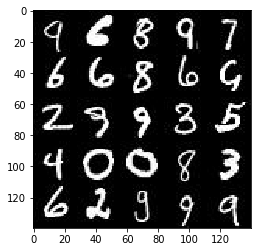

In [3]:
data_dir = './data'
import helper
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

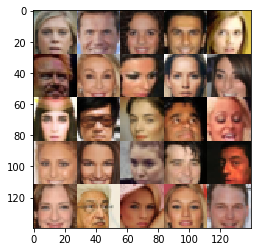

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_height, image_width, image_channels), name='input_real')
    z_data = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='input_z')
    learn_rate = tf.placeholder(dtype=tf.float32)
    return real_input, z_data, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28s28x(1 or 3)
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=4, strides=2, padding='valid')
        relu1 = tf.maximum(alpha * x1, x1)
        # 13x13x64
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=3, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 6x6x128
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=2, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 3x3x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 3*3*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=2, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 6x6x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=3, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 13x13x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size=4, strides=2, padding='valid')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    # Tell TensorFlow to update the population statistics while training
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    steps = 0
    print_every = 10
    show_every = 100
    lr_alpha = 0.02 #leaky relu slope
    
    
#     img_channels = 0
#     if data_image_mode is "RGB":
#         img_channels = 3
#     if data_image_mode is "L":
#         img_channels = 1
        
#     print("Data shape: {}".format(*data_shape))
    
    width = data_shape[1]
    height = data_shape[2]
    channels = data_shape[3]
    
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,channels, alpha=lr_alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images, learn_rate: learning_rate })
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    n_images = 9
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
    print("-------Done-------")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.7080... Generator Loss: 0.0506
Epoch 1/2... Discriminator Loss: 3.6902... Generator Loss: 0.0454
Epoch 1/2... Discriminator Loss: 3.7917... Generator Loss: 0.0387
Epoch 1/2... Discriminator Loss: 4.0698... Generator Loss: 0.0350
Epoch 1/2... Discriminator Loss: 4.1970... Generator Loss: 0.0292
Epoch 1/2... Discriminator Loss: 4.0828... Generator Loss: 0.0343
Epoch 1/2... Discriminator Loss: 3.7222... Generator Loss: 0.0495
Epoch 1/2... Discriminator Loss: 4.2881... Generator Loss: 0.0354
Epoch 1/2... Discriminator Loss: 3.7630... Generator Loss: 0.0520
Epoch 1/2... Discriminator Loss: 2.9959... Generator Loss: 0.1043


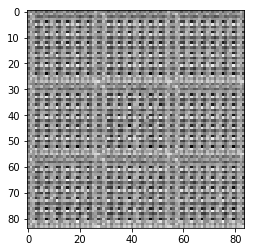

Epoch 1/2... Discriminator Loss: 3.2583... Generator Loss: 0.0948
Epoch 1/2... Discriminator Loss: 3.3368... Generator Loss: 0.1018
Epoch 1/2... Discriminator Loss: 3.2635... Generator Loss: 0.1190
Epoch 1/2... Discriminator Loss: 3.5181... Generator Loss: 0.1206
Epoch 1/2... Discriminator Loss: 3.2976... Generator Loss: 0.1217
Epoch 1/2... Discriminator Loss: 3.5374... Generator Loss: 0.1481
Epoch 1/2... Discriminator Loss: 3.2352... Generator Loss: 0.1632
Epoch 1/2... Discriminator Loss: 2.8799... Generator Loss: 0.2323
Epoch 1/2... Discriminator Loss: 2.6274... Generator Loss: 0.2683
Epoch 1/2... Discriminator Loss: 2.5663... Generator Loss: 0.3254


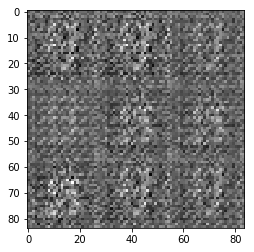

Epoch 1/2... Discriminator Loss: 2.6748... Generator Loss: 0.3007
Epoch 1/2... Discriminator Loss: 2.6050... Generator Loss: 0.3092
Epoch 1/2... Discriminator Loss: 2.4286... Generator Loss: 0.3900
Epoch 1/2... Discriminator Loss: 2.4289... Generator Loss: 0.3936
Epoch 1/2... Discriminator Loss: 2.4419... Generator Loss: 0.4144
Epoch 1/2... Discriminator Loss: 2.2791... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 2.2769... Generator Loss: 0.4519
Epoch 1/2... Discriminator Loss: 2.2336... Generator Loss: 0.4427
Epoch 1/2... Discriminator Loss: 2.0922... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 2.0291... Generator Loss: 0.4933


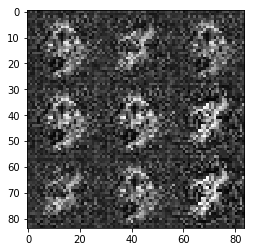

Epoch 1/2... Discriminator Loss: 2.0271... Generator Loss: 0.5224
Epoch 1/2... Discriminator Loss: 1.9479... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 1.9637... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.9148... Generator Loss: 0.5758
Epoch 1/2... Discriminator Loss: 1.8261... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 1.7976... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.7259... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.8261... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.6406... Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 1.5146... Generator Loss: 0.6646


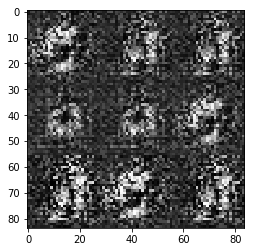

Epoch 1/2... Discriminator Loss: 1.6877... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.8469... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 1.8310... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 1.7404... Generator Loss: 0.5851
Epoch 1/2... Discriminator Loss: 1.9654... Generator Loss: 0.5336
Epoch 1/2... Discriminator Loss: 1.8033... Generator Loss: 0.5724
Epoch 2/2... Discriminator Loss: 1.7663... Generator Loss: 0.6332
Epoch 2/2... Discriminator Loss: 1.6425... Generator Loss: 0.6557
Epoch 2/2... Discriminator Loss: 1.8555... Generator Loss: 0.5276
Epoch 2/2... Discriminator Loss: 1.7536... Generator Loss: 0.5823


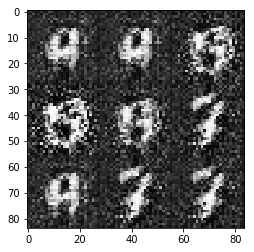

Epoch 2/2... Discriminator Loss: 1.5532... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.6293... Generator Loss: 0.6219
Epoch 2/2... Discriminator Loss: 1.6635... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.5805... Generator Loss: 0.6477
Epoch 2/2... Discriminator Loss: 1.5846... Generator Loss: 0.6561
Epoch 2/2... Discriminator Loss: 1.5369... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.4657... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 0.8346


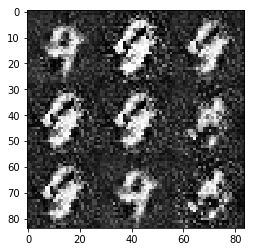

Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 0.8205
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 0.8585


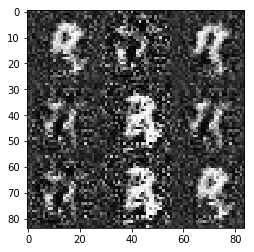

Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.7686
Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.5506... Generator Loss: 0.6229
Epoch 2/2... Discriminator Loss: 1.5186... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.7894


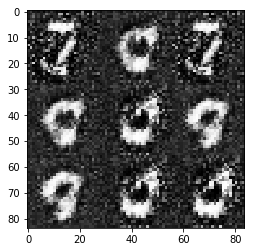

Epoch 2/2... Discriminator Loss: 1.4828... Generator Loss: 0.7692
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.8844
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 0.8095


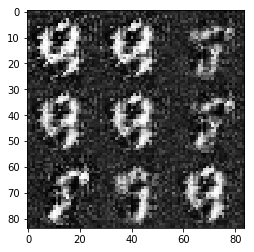

Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 0.9254
-------Done-------


In [14]:
batch_size = 128
z_dim = 1
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1168... Generator Loss: 0.0859
Epoch 1/1... Discriminator Loss: 2.9367... Generator Loss: 0.1528
Epoch 1/1... Discriminator Loss: 2.4406... Generator Loss: 0.2914
Epoch 1/1... Discriminator Loss: 2.1273... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 2.0938... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 2.1370... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 2.0543... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 2.0257... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.8024... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.8911... Generator Loss: 0.5868


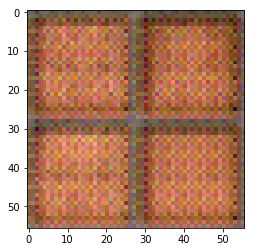

Epoch 1/1... Discriminator Loss: 1.7548... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.7341... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.2567


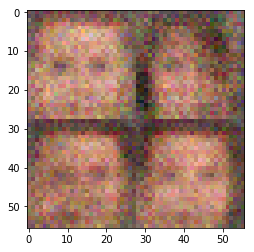

Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.3500
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 2.3008
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 1.7900
Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 2.2854
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 1.5084


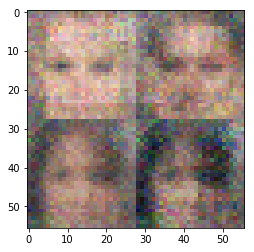

Epoch 1/1... Discriminator Loss: 1.7196... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 2.5100
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 1.9242
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.7112
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 1.9764
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 3.4041
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.7403


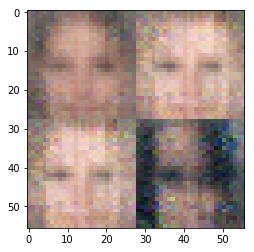

Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.8852
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 2.1335
Epoch 1/1... Discriminator Loss: 0.2357... Generator Loss: 2.8521
Epoch 1/1... Discriminator Loss: 0.3416... Generator Loss: 1.9537
Epoch 1/1... Discriminator Loss: 0.3190... Generator Loss: 2.4931
Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 0.2972... Generator Loss: 2.7732
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 2.0717


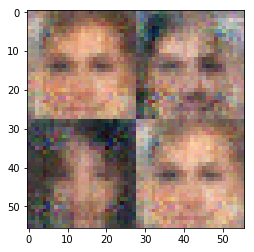

Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 2.8366
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 2.8542
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 2.6879
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 2.1544


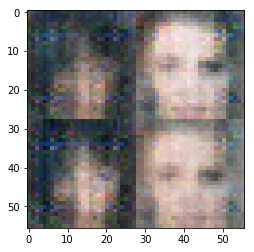

Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 1.9430
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 2.3932
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 0.2410... Generator Loss: 2.4830
Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 1.9814
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.2663
Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 2.2575
Epoch 1/1... Discriminator Loss: 0.1245... Generator Loss: 4.5425
Epoch 1/1... Discriminator Loss: 0.2231... Generator Loss: 2.6270
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 3.9888


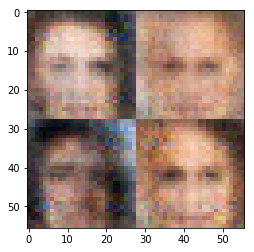

Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 2.7542
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 2.1191
Epoch 1/1... Discriminator Loss: 0.3196... Generator Loss: 2.0824
Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 1.8318
Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 2.2396
Epoch 1/1... Discriminator Loss: 0.3038... Generator Loss: 1.8155
Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 3.0525
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.5925
Epoch 1/1... Discriminator Loss: 2.1254... Generator Loss: 3.7904
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.2846


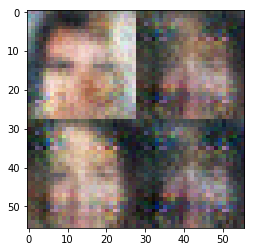

Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 0.2075... Generator Loss: 2.7485
Epoch 1/1... Discriminator Loss: 0.1069... Generator Loss: 3.7220
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 2.1896
Epoch 1/1... Discriminator Loss: 0.2355... Generator Loss: 2.9680
Epoch 1/1... Discriminator Loss: 0.1326... Generator Loss: 3.6369
Epoch 1/1... Discriminator Loss: 0.1095... Generator Loss: 4.1319
Epoch 1/1... Discriminator Loss: 0.3050... Generator Loss: 2.4378
Epoch 1/1... Discriminator Loss: 0.1983... Generator Loss: 2.5123
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 1.0722


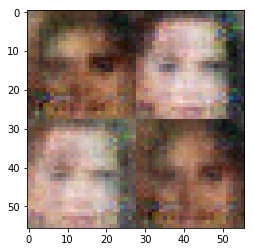

Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 2.5644
Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 4.1098
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 5.7126
Epoch 1/1... Discriminator Loss: 0.2246... Generator Loss: 2.0764
Epoch 1/1... Discriminator Loss: 0.2061... Generator Loss: 2.7078
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 2.9116
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 3.4502
Epoch 1/1... Discriminator Loss: 0.1307... Generator Loss: 2.7359
Epoch 1/1... Discriminator Loss: 0.2828... Generator Loss: 1.6987
Epoch 1/1... Discriminator Loss: 0.1465... Generator Loss: 2.8029


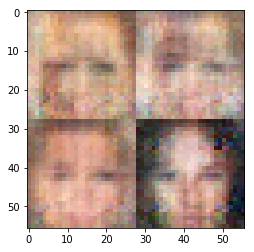

Epoch 1/1... Discriminator Loss: 0.1423... Generator Loss: 3.3129
Epoch 1/1... Discriminator Loss: 0.2210... Generator Loss: 2.3760
Epoch 1/1... Discriminator Loss: 0.0948... Generator Loss: 3.9780
Epoch 1/1... Discriminator Loss: 0.2325... Generator Loss: 2.3916
Epoch 1/1... Discriminator Loss: 3.1894... Generator Loss: 0.0576
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 1.7717
Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 2.2759
Epoch 1/1... Discriminator Loss: 0.1921... Generator Loss: 3.1426
Epoch 1/1... Discriminator Loss: 0.2658... Generator Loss: 2.4191


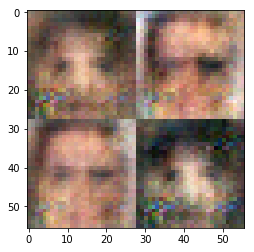

Epoch 1/1... Discriminator Loss: 0.1140... Generator Loss: 4.6313
Epoch 1/1... Discriminator Loss: 0.2275... Generator Loss: 2.3297
Epoch 1/1... Discriminator Loss: 0.1317... Generator Loss: 3.0419
Epoch 1/1... Discriminator Loss: 0.3061... Generator Loss: 1.7652
Epoch 1/1... Discriminator Loss: 0.1960... Generator Loss: 3.1909
Epoch 1/1... Discriminator Loss: 0.1522... Generator Loss: 4.1854
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 1.5327
Epoch 1/1... Discriminator Loss: 0.0858... Generator Loss: 3.5471
Epoch 1/1... Discriminator Loss: 0.0883... Generator Loss: 6.7721
Epoch 1/1... Discriminator Loss: 0.2748... Generator Loss: 3.5474


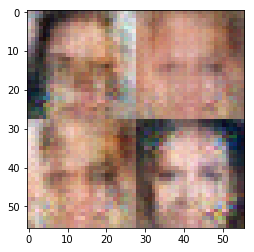

Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 2.9823
Epoch 1/1... Discriminator Loss: 0.2228... Generator Loss: 2.0202
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 3.0691
Epoch 1/1... Discriminator Loss: 0.1133... Generator Loss: 3.5338
Epoch 1/1... Discriminator Loss: 0.0915... Generator Loss: 4.2352
Epoch 1/1... Discriminator Loss: 0.1988... Generator Loss: 3.4064
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 3.9965
Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 3.7667
Epoch 1/1... Discriminator Loss: 0.1831... Generator Loss: 3.4030
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 1.8021


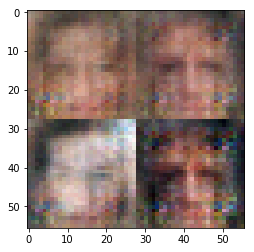

Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 1.7350
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 4.2133
Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.1831
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 2.2587
Epoch 1/1... Discriminator Loss: 0.1603... Generator Loss: 3.1941
Epoch 1/1... Discriminator Loss: 0.1285... Generator Loss: 3.9931
Epoch 1/1... Discriminator Loss: 0.1331... Generator Loss: 3.5464
Epoch 1/1... Discriminator Loss: 0.1222... Generator Loss: 3.5886
Epoch 1/1... Discriminator Loss: 0.2676... Generator Loss: 2.5171


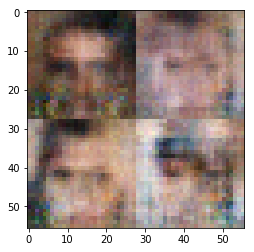

Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 1.9098
Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 2.7232
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 2.0500
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 1.4083
Epoch 1/1... Discriminator Loss: 0.1468... Generator Loss: 2.8115
Epoch 1/1... Discriminator Loss: 0.2331... Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 4.7457
Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 4.2936
Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 4.9684
Epoch 1/1... Discriminator Loss: 0.0768... Generator Loss: 4.0823


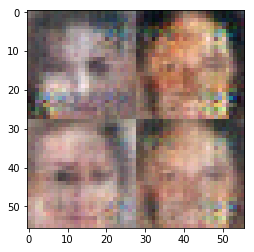

Epoch 1/1... Discriminator Loss: 0.2008... Generator Loss: 2.6955
Epoch 1/1... Discriminator Loss: 0.2245... Generator Loss: 2.4255
Epoch 1/1... Discriminator Loss: 2.2693... Generator Loss: 6.2167
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 1.5606
Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 1.8967
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 3.6688
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 2.7547


In [115]:
batch_size = 128
z_dim = 3
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.